In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot 
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16


# Постановка задачи

Задача Римана для одномерной нестационарной системы уравнений Эйлера прелставлеяет собой задачу Коши для законов сохранения

\begin{equation}
\left . 
\begin{array}{c}
\mathbf{U}_t + \mathbf{F}(\mathbf{U})_x = 0, \\
\mathbf{U} = \left[\begin{array}{c}\rho \\ \rho u  \\E \end{array}\right], 
\mathbf{F} = \left[\begin{array}{c}\rho u \\ \rho u^2+p  \\ u(E+p) \end{array}\right],
\end{array}
\right\}
\end{equation}

с начальными условиями

\begin{equation}
\mathbf{U}(x,0)=\mathbf{U}^{(0)}(x) = 
\left \{ 
\begin{array}{c}
\mathbf{U}_L ~\textrm{если} ~x<0, \\
\mathbf{U}_R ~\textrm{если} ~x>0.
\end{array}
\right .
\end{equation}

При решении задачи Римана будем использовать вектор примитивных переменных $\mathbf{W} = (\rho, u, p)^T$ вместо консервативных переменных (вектор $\mathbf{U}$). Тогда начальные условия задаются в виде двух векторов $\mathbf{W}_L = (\rho_L, u_L, p_L)^T$ для области слева от $x=0$ и $\mathbf{W}_R = (\rho_R, u_R, p_R)^T$ для области справа от $x=0$, области разделены скачком в $x=0$. Нужно найти решение в области, обозначенной на рисунке как _Star Region_.

![Схема задачи Римана](./figures/star_region.png "Схема задачи Римана")

Система уравнений замыкается уравнением состояния

\begin{equation}
e = \frac{p}{(\gamma -1) \rho}
\end{equation}

# Уравнения для давления и скорости

Согласно Торо, значение давления в интересующей нас области это корень алгебраического уравнения:

\begin{equation}
f(p,\mathbf{W}_L,\mathbf{W}_R) \equiv f_L(p,\mathbf{W}_L) +f_R(p,\mathbf{W}_R) + \Delta u = 0, ~ \Delta u \equiv u_R - u_L,
\end{equation}

где функция $f_L$ задается соотношением

\begin{equation}
f_L(p,\mathbf{W}_L) = 
\left \{ 
\begin{array}{ll}
(p-p_L)\left[ \frac{A_L}{p+B_L} \right]^\frac{1}{2} &~\textrm{если} ~ p>p_L ~(скачок),& \\
\frac{2a_L}{(\gamma-1)}\left[ \left(\frac{p}{p_L} \right)^\frac{\gamma-1}{2\gamma} -1 \right] &~\textrm{если} ~p\leq p_L ~(разрежение),&
\end{array}
\right .
\end{equation}

функция $f_R$ задается соотношением

\begin{equation}
f_R(p,\mathbf{W}_R) = 
\left \{ 
\begin{array}{ll}
(p-p_R)\left[ \frac{A_R}{p+B_R} \right]^\frac{1}{2} &~\textrm{если} ~ p>p_R ~(скачок),& \\
\frac{2a_R}{(\gamma-1)}\left[ \left(\frac{p}{p_R} \right)^\frac{\gamma-1}{2\gamma} -1 \right] &~\textrm{если} ~p\leq p_R ~(разрежение),&
\end{array}
\right .
\end{equation}

а константы $A_L,~B_L,~A_R,~B_R$ задаются как

\begin{equation}
\left .
\begin{array}{ll}
A_L = \frac{2}{(\gamma+1)\rho_L},~B_L = \frac{(\gamma -1)}{(\gamma +1)}p_L,\\
A_R = \frac{2}{(\gamma+1)\rho_R},~B_R = \frac{(\gamma -1)}{(\gamma +1)}p_R.
\end{array}
\right \}
\end{equation}

Скорость вычисляется из соотношения
\begin{equation}
u_*=\frac{1}{2}(u_L+u_R) + \frac{1}{2}[f_R(p_*) - f_L(p_*)].
\end{equation}

In [104]:
def init(case):
    if case == 'sod':
        left_state = np.array([1.,0.,1.])
        right_state = np.array([0.125,0.,0.1])
        time = 0.2
    if case == '123':
        left_state = np.array([1.,-2.,0.4])
        right_state = np.array([1.,2.0,0.4])
        time = 0.15
    if case == 'Left Woodward':
        left_state = np.array([1.,0.,1000.0])
        right_state = np.array([1.,0.,0.01])
        time = 0.012
    return {'left':left_state,'right':right_state,'timeout':time}

In [24]:
#Различные формулы из гаммы
g_m_1_over_2g = (gamma-1)/2/gamma      #g1
g_p_1_over_2g = (gamma+1)/2/gamma      #g2
g_m_1_over_2g_inv = 1/g_m_1_over_2g    #g3
g_m_1_over_2_inv = 2/(gamma-1)         #g4
g_p_1_over_2_inv = 2/(gamma+1)         #g5
g_m_1_over_g_p_1 = (gamma-1)/(gamma+1) #g6
g_m_1_over_2 = (gamma-1)/2             #g7
g_m_1 = gamma-1                        #g8

In [6]:
def calc_f(p,d_k,p_k,c_k):
    if p <= p_k:
        #Волна разрежения
        ratio_p = p/p_k
        f = g_m_1_over_2_inv*c_k*(ratio_p**g_m_1_over_2g-1)
        f_deriv = (1./(d_k*c_k))*ratio_p**(-g_p_1_over_2g)
    else:
        #Скачок уплотнения
        A_K = g_p_1_over_2_inv/d_k
        B_K = g_m_1_over_g_p_1*p_k
        f = (p-p_k)*(A_K/(B_K+p))**0.5
        f_deriv = (1-0.5*(p-p_k)/(B_K+p))*(A_K/(B_K+p))**0.5
    return f,f_deriv

In [113]:
#def guess_p(d_l, u_l, p_l,c_l,d_r, u_r, p_r, c_r):
def guess_p(W_l,c_l,W_r, c_r):
    
    d_l, u_l, p_l = W_l
    d_r, u_r, p_r = W_r
    q_temp = 2.0
    
    p_pv = max(0.0, 0.5*(p_l+p_r)-0.125*(u_r-u_l)*(d_l+d_r)*(c_l+c_r))
    p_min = min(p_l,p_r)
    p_max = max(p_l,p_r)
    q_max = p_max/p_min
    
    if q_max <= q_temp and p_min<=p_pv<=p_max:
        #PVRS (приближение по примитивным переменным)
        p_m = p_pv
    
    elif p_pv < p_min:
        #Приближение двух волн разрежения
        p_m = ( (c_l+c_r-0.5*g_m_1*(u_r-u_l))/(c_l/p_l**g_m_1_over_2g + c_r/p_r**g_m_1_over_2g) )**g_m_1_over_2g_inv
    else:
        #Приближение двух скачков
        g_l = ((g_p_1_over_2_inv/d_l)/(g_m_1_over_g_p_1*p_l+p_pv))**0.5
        g_r = ((g_p_1_over_2_inv/d_r)/(g_m_1_over_g_p_1*p_r+p_pv))**0.5
        p_m = (g_l*p_l+g_r*p_r - (u_r-u_l))/(g_l+g_r)
        
        
    return p_m
        
        


In [114]:
def sample(d_l, u_l, p_l,c_l,d_r, u_r, p_r, c_r, p_m, u_m, s):
    """Returns d,u,p in sampled point according the shock and wave configuration"""
    if s<= u_m:
        #точка лежит слева от контактного разрыва
        if p_m <= p_l: #слева -- волна разрежения
            head_speed_l = u_l - c_l   #скорость головной характеристики волны разрежения
            
            if s<= head_speed_l: #точка лежит слева от волны -- все значения из левой ячейки
                d = d_l
                u = u_l
                p = p_l
            else:
                c_m_l = c_l*(p_m/p_l)**g_m_1_over_2g #скорость звука справа от левой волны
                tail_speed_l = u_m - c_m_l        #скорость замыкающей характеристики волны разрежения
                
                if s>=tail_speed_l:              #точка лежит между волной и контактным разрывом
                    
                    d = d_l*(p_m/p_l)**(1./gamma)
                    u = u_m
                    p = p_m
                
                else:                              #точка лежит в веере волны разрежения
                    u = g_p_1_over_2_inv*(c_l+g_m_1_over_2*u_l+s)
                    c = u - s
                    d = d_l*(c/c_l)**g_m_1_over_2_inv
                    p = p_l*(c/c_l)**g_m_1_over_2g_inv
        
        else:       #слева -- скачок 
            shock_ratio = p_m/p_l
            s_l = u_l - c_l*(g_p_1_over_2g*shock_ratio + g_m_1_over_2g)**0.5 #скорость скачка
            
            if s<= s_l: #точка лежит слева от скачка -- все значения из левой ячейки
                d = d_l
                u = u_l
                p = p_l
            else:   #точка лежит между скачком и контактным разрывом
                
                d = d_l*(shock_ratio + (gamma-1)/(gamma+1))/((gamma-1)/(gamma+1)*shock_ratio +1.)
                u = u_m
                p = p_m
    #----------------------------------------------------------------------------------------------------
    else:              #точка лежит справа от контактного разрыва
        
        if p_m > p_r:   #справа -- скачок
            shock_ratio = p_m/p_r
            s_r = u_r + c_r*(g_p_1_over_2g*shock_ratio + g_m_1_over_2g)**0.5 #скорость скачка
            
            if s >= s_r: #точка лежит справа от скачка -- все значения из правой ячейки
                d = d_r
                u = u_r
                p = p_r
            else:   #точка лежит между скачком и контактным разрывом
                
                d = d_r*(shock_ratio + g_m_1_over_g_p_1)/(g_m_1_over_g_p_1*shock_ratio +1.)
                u = u_m
                p = p_m
        else:           #справа -- волна
            
            head_speed_r = u_r + c_r   #скорость головной характеристики волны разрежения
            
            if s >= head_speed_r: #точка лежит справа от волны -- все значения из правой ячейки
                d = d_r
                u = u_r
                p = p_r
            else:
                c_m_r = c_r*(p_m/p_r)**g_m_1_over_2g #скорость звука слева от правой волны
                tail_speed_r = u_m + c_m_r           #скорость замыкающей характеристики волны разрежения
                
                if s<=tail_speed_r:              #точка лежит между контактным разрывом и волной
                    
                    d = d_r*(p_m/p_r)**(1/gamma)
                    u = u_m
                    p = p_m
                
                else:                              #точка лежит в веере волны разрежения
                    u = g_p_1_over_2_inv*(-c_r+g_m_1_over_2*u_r+s)
                    c = -u + s
                    d = d_r*(c/c_r)**g_m_1_over_2_inv
                    p = p_r*(c/c_r)**g_m_1_over_2g_inv
                
    return d,u,p

In [98]:
def find_in_star(W_l,c_l,W_r,c_r):
    p_old = guess_p(W_l,c_l,W_r,c_r)
    u_diff = W_r[1] -W_l[1]
    
    i=0
    change = 100
    
    while change > tol and i<20:
        print("Iteration NR ={}".format(i))
        
        f_l,f_deriv_l = calc_f(p_old,W_l[0],W_l[2],c_l)
        f_r,f_deriv_r = calc_f(p_old,W_r[0],W_r[2],c_r)
        print("Guess p ={}".format(p_old))
        p = p_old - (f_l + f_r + u_diff)/(f_deriv_l+f_deriv_r)
        change = 2*np.abs((p-p_old)/(p+p_old))
        print("New p = {:.6f}".format(p))
        if p < 0. :
            p = tol
        p_old = p
        i = i+1
    
    p_m = p
    u_m = 0.5*(W_l[1] + W_r[1] + f_r - f_l )
    return u_m,p_m

In [ ]:
length = 1.     # Длина участка
N = 1001        # Число ячеек
x_dis = 0.5     #Положение разрыва
tol = 1.0E-06
gamma = 1.4     #Гамма, она же каппа
test='Left Woodward'
t_out = init(test)['timeout']     #Отрезок времени
d_l, u_l, p_l = init(test)['left']
d_r, u_r, p_r = init(test)['right']
W_l = np.array([d_l, u_l, p_l])
W_r = np.array([d_r, u_r, p_r])

#Скорости звука справа и слева
c_l = (gamma*p_l/d_l)**0.5
c_r = (gamma*p_r/d_r)**0.5

In [115]:
dx = length/(N-1)
x = np.linspace(0,1,N)[1:]-0.5*dx
W_init = np.zeros((N-1,3))
W_init[np.where(x<=x_dis),:] = W_l
W_init[np.where(x>x_dis),:] = W_r
W = W_init.copy()

In [116]:
u_m,p_m = find_in_star(W_l,c_l,W_r,c_r)
print(p_m,u_m)
for i,x_ in enumerate(x):
    #print(i)
    s = (x_ - x_dis)/t_out
    #print (s)
    
    W[i] = sample(*W_l,c_l,*W_r,c_r,p_m,u_m,s)

Iteration NR =0
Guess p =464.10769951484457
New p = 460.885371
Iteration NR =1
Guess p =460.8853711108047
New p = 460.893787
Iteration NR =2
Guess p =460.89378743348914
New p = 460.893787
460.893787491 19.5974513896


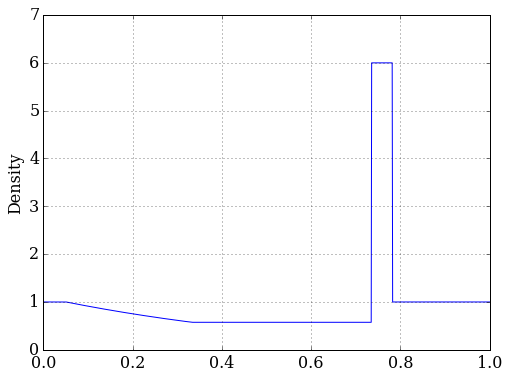

In [120]:
pyplot.figure(figsize=(8,6))
pyplot.xlim(0,1)
pyplot.ylim(0,7)
pyplot.plot(x,W[:,0])
pyplot.grid()
pyplot.ylabel('Density')

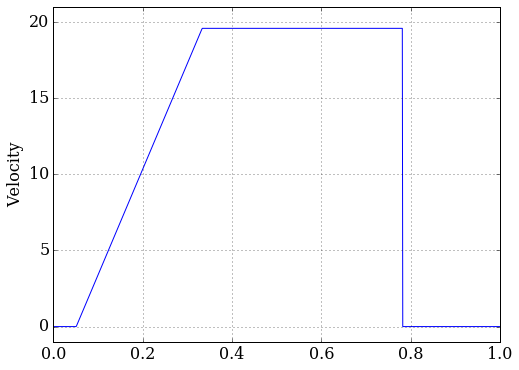

In [124]:
pyplot.figure(figsize=(8,6))
pyplot.xlim(0,1)
pyplot.ylim(-1,21)
pyplot.plot(x,W[:,1])
pyplot.grid()
pyplot.ylabel('Velocity')

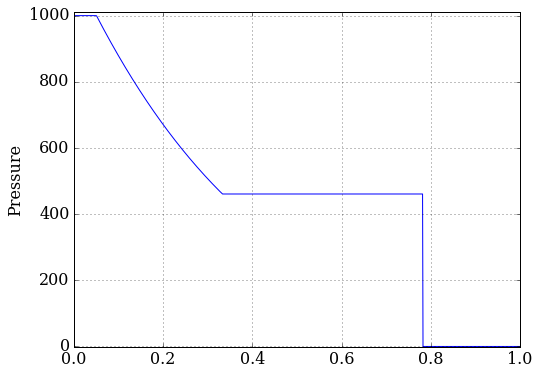

In [127]:
pyplot.figure(figsize=(8,6))
pyplot.xlim(0,1)
pyplot.ylim(-1,1011)
pyplot.plot(x,W[:,2])
pyplot.grid()
pyplot.ylabel('Pressure')

In [2]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())